In [1]:
import argparse
import time
import os
from random import sample
import numpy as np

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem import QED
from rdkit.Chem import AllChem, Draw
from rdkit import DataStructs

from scaffold_constrained_model import scaffold_constrained_RNN
from train_agent import train_agent
from data_structs import Vocabulary, Experience
from scoring_functions import get_scoring_function
from utils import Variable, seq_to_smiles, fraction_valid_smiles, unique
from rdkit.Chem.Draw import IPythonConsole

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import torch

import warnings
warnings.filterwarnings('ignore')

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

%matplotlib inline 
# Loading trained model and appropriate vocabulary

run_experiments = True

voc = Vocabulary(init_from_file="data/DistributionLearningBenchmark/Voc")
    
Agent = scaffold_constrained_RNN(voc)
print(Agent.rnn.state_dict)
if torch.cuda.is_available():
    Agent.rnn.load_state_dict(torch.load('data/DistributionLearningBenchmark/Prior_ChEMBL_randomized.ckpt'))
else:
    Agent.rnn.load_state_dict(torch.load('data/DistributionLearningBenchmark/Prior_ChEMBL_randomized.ckpt', map_location=lambda storage, loc: storage))

<bound method Module.state_dict of MultiGRU(
  (embedding): Embedding(50, 128)
  (gru_1): GRUCell(128, 512)
  (gru_2): GRUCell(512, 512)
  (gru_3): GRUCell(512, 512)
  (linear): Linear(in_features=512, out_features=50, bias=True)
)>


In [2]:
# calculation of synthetic accessibility score as described in:
#
# Estimation of Synthetic Accessibility Score of Drug-like Molecules based on Molecular Complexity and Fragment Contributions
# Peter Ertl and Ansgar Schuffenhauer
# Journal of Cheminformatics 1:8 (2009)
# http://www.jcheminf.com/content/1/1/8
#
# several small modifications to the original paper are included
# particularly slightly different formula for marocyclic penalty
# and taking into account also molecule symmetry (fingerprint density)
#
# for a set of 10k diverse molecules the agreement between the original method
# as implemented in PipelinePilot and this implementation is r2 = 0.97
#
# peter ertl & greg landrum, september 2013
#

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import pickle

import math
from collections import defaultdict

import os.path as op

_fscores = None


def readFragmentScores(name='fpscores'):
    import gzip
    global _fscores
    # generate the full path filename:

    data = pickle.load(gzip.open('fpscores.pkl.gz'))
    outDict = {}
    for i in data:
        for j in range(1, len(i)):
            outDict[i[j]] = float(i[0])
    _fscores = outDict


def numBridgeheadsAndSpiro(mol, ri=None):
    nSpiro = rdMolDescriptors.CalcNumSpiroAtoms(mol)
    nBridgehead = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
    return nBridgehead, nSpiro


def calculateScore(m):
    if _fscores is None:
        readFragmentScores()

    # fragment score
    fp = rdMolDescriptors.GetMorganFingerprint(m,
                                               2)  # <- 2 is the *radius* of the circular fingerprint
    fps = fp.GetNonzeroElements()
    score1 = 0.
    nf = 0
    for bitId, v in fps.items():
        nf += v
        sfp = bitId
        score1 += _fscores.get(sfp, -4) * v
    score1 /= nf

    # features score
    nAtoms = m.GetNumAtoms()
    nChiralCenters = len(Chem.FindMolChiralCenters(m, includeUnassigned=True))
    ri = m.GetRingInfo()
    nBridgeheads, nSpiro = numBridgeheadsAndSpiro(m, ri)
    nMacrocycles = 0
    for x in ri.AtomRings():
        if len(x) > 8:
            nMacrocycles += 1

    sizePenalty = nAtoms**1.005 - nAtoms
    stereoPenalty = math.log10(nChiralCenters + 1)
    spiroPenalty = math.log10(nSpiro + 1)
    bridgePenalty = math.log10(nBridgeheads + 1)
    macrocyclePenalty = 0.
    # ---------------------------------------
    # This differs from the paper, which defines:
    #  macrocyclePenalty = math.log10(nMacrocycles+1)
    # This form generates better results when 2 or more macrocycles are present
    if nMacrocycles > 0:
        macrocyclePenalty = math.log10(2)

    score2 = 0. - sizePenalty - stereoPenalty - spiroPenalty - bridgePenalty - macrocyclePenalty

    # correction for the fingerprint density
    # not in the original publication, added in version 1.1
    # to make highly symmetrical molecules easier to synthetise
    score3 = 0.
    if nAtoms > len(fps):
        score3 = math.log(float(nAtoms) / len(fps)) * .5

    sascore = score1 + score2 + score3

    # need to transform "raw" value into scale between 1 and 10
    min = -4.0
    max = 2.5
    sascore = 11. - (sascore - min + 1) / (max - min) * 9.
    # smooth the 10-end
    if sascore > 8.:
        sascore = 8. + math.log(sascore + 1. - 9.)
    if sascore > 10.:
        sascore = 10.0
    elif sascore < 1.:
        sascore = 1.0

    return sascore


def processMols(mols):
    print('smiles\tName\tsa_score')
    for i, m in enumerate(mols):
        if m is None:
            continue

        s = calculateScore(m)

        smiles = Chem.MolToSmiles(m)
        print(smiles + "\t" + m.GetProp('_Name') + "\t%3f" % s)


#
#  Copyright (c) 2013, Novartis Institutes for BioMedical Research Inc.
#  All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are
# met:
#
#     * Redistributions of source code must retain the above copyright
#       notice, this list of conditions and the following disclaimer.
#     * Redistributions in binary form must reproduce the above
#       copyright notice, this list of conditions and the following
#       disclaimer in the documentation and/or other materials provided
#       with the distribution.
#     * Neither the name of Novartis Institutes for BioMedical Research Inc.
#       nor the names of its contributors may be used to endorse or promote
#       products derived from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
# "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
# LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR
# A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT
# OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
# SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT
# LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE,
# DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY
# THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [3]:
def int_diversity(smiles):
    if len(smiles)==0:
        return 0.5
    diversity = 0
    for s in smiles:
        fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 4)
        for m in smiles:
            query_fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(m), 4)
            diversity += DataStructs.TanimotoSimilarity(query_fp, fp) 
    diversity /= len(smiles)**2
    return 1 - diversity

def validity_and_uniqueness_assessement(pattern= "c1c(*)cc2c(c1)c(*)ccn2", refs = None, n_tryouts=5000, save_path="experiments_outputs/"):
    n_valid = 0
    n_unique = 0
    logP = []
    MW = []
    qed_list = []
    SAS = []
    HD_list = []
    HA_list = []
    smiles = []
        
    seqs, agent_likelihood, entropy = Agent.sample(pattern, batch_size=n_tryouts)
        #seqs, agent_likelihood, entropy = Agent.sample(1)
    for seq in seq_to_smiles(seqs, voc):
        mol = Chem.MolFromSmiles(seq)
    
        if mol:
            n_valid += 1

            if Chem.MolToSmiles(mol) not in smiles:
                smiles.append(Chem.MolToSmiles(mol))
                n_unique += 1
            try:
                SAS.append(calculateScore(mol))
                MW.append(Descriptors.ExactMolWt(mol))
                logP.append(Descriptors.MolLogP(mol))
                qed_list.append(QED.qed(mol))
                HA_list.append(Lipinski.NumHAcceptors(mol))
                HD_list.append(Lipinski.NumHDonors(mol))
            except:
                pass
    
    if save_path:
        
        df_summary = pd.DataFrame(columns = ["Scaffold", "Percentage valid molecules", "Percentage unique molecules"])
        df_summary["Scaffold"] = [pattern]
        df_summary["Percentage valid molecules"] = [n_valid/n_tryouts]
        df_summary["Percentage unique molecules"] = [n_unique/n_valid]

        df_details = pd.DataFrame(columns = ["Molecular weight",
                                    "Calculated log P", "Synthetizability Accessibility Score (SAS)", "Quantitative Estimate of Drug-likeness (QED)",
                                    "Number of H bonds acceptors", "Number of H bonds donors"])
        df_details["Molecular weight"] = MW
        df_details["Calculated log P"] = logP
        df_details["Synthetizability Accessibility Score (SAS)"] = SAS
        df_details["Quantitative Estimate of Drug-likeness (QED)"] = qed_list
        df_details["Number of H bonds acceptors"] = HA_list
        df_details["Number of H bonds donors"] = HD_list
        
        df_details.to_csv(save_path + "_details.csv")
        df_summary.to_csv(save_path + "_summary.csv")

    validity = [n_valid/n_tryouts]
    unicities = [n_unique/n_valid]

    print("On a set of {} generated molecules based on the scaffold {}, we obtain the following average metrics:\nlogP = {:.4f}\nSAS = {:.4f}\nQED = {:.4f}\nMW = {:.4f}\nHBA = {:.4f}\nHBD = {:.4f}".format(len(MW), pattern, np.mean(logP), np.mean(SAS), np.mean(qed_list), np.mean(MW), np.mean(logP), np.mean(HA_list), np.mean(HD_list)))
    print("We obtain the following validity and uniqueness results:\nOn average,\n\tthe percentage of valid generated molecules is {:.4f}\n\tthe percentage of unique generated molecules is {:.4f}\n".format(np.mean(validity), np.mean(unicities)))
    
    return n_valid/n_tryouts, n_unique/n_valid, MW, logP, SAS, qed_list, HA_list, HD_list, smiles

In [4]:
# patterns = ['N(*)2C(=C)N(c3ccc(C#N)c(C(F)(F)F)c3)C(=O)C23CCC3',
#  'C(*)N2CCN(C(=O)Oc3cncc(*)c3)C(C)C2',
#  'c(*)1ccc(Nc2cnc(N)c(NCc3ccc4ncccc4c3)n2)nc1',
#  'N(*)C(=O)C(=O)N2CCC(c3ccnc4ccc(*)cc34)CC2',
#  'C(*)c1nc(=O)c(S(=O)(=O)c2ccc(*)c(*)c2)c(O)n1(*)',
#  'C(*)c1cnn(CC2C(NC(=O)C(=NOC3(C(*)O)CC3)c3csc(*)n3)C(=O)N2(*))n1',
#  'C(*)Oc1cc(*)c(*)c(c2ccc3nc(N(*))ncc3c2)c1(*)',
#  'c(*)1cnc2cc(*)c(*)cc2c1N1CCN(*)C(*)C1',
#  'c1(*)cnc2cc(*)c(*)cc2c1N1CCNCC1',
#  'C(*)NC2=NN=C(c3ccc4[nH]c(=O)[nH]c4c3)CS2',
#  'C(*)#Cc1ccc(OCc2nnc(S(*))n2-c2cccnc2)cc1(*)',
#  'C(*)C1=C(*)C(*)N=C(c2nccs2)N1',
#  'S(*)(C)(=O)CC(c1ccc(OC)cc1)n1c(=O)n(*)c2cc(-c3ccccc3(*))ccc21',
#  'c(*)1ccc2[nH]c3c(c2c1)CN(c1ccc2oc(N4CCOCC4)nc2c1)CC3',
#  'c(*)1cc(Nc2ncc(*)c(Nc3ccccc3(*))n2)c(O(*))cc1C(*)',
#  'C=C(*)C(=O)CC(=O)C=C(*)',
#  'C(*)N(CC2=C(C(=O)OCC)C(c3ccc(F)cc3(*))N=C(c3nccs3)N2)']

# drd2_patterns = ['c1(*)cccc2c1OCC(N(*)C(*))C2',
#                  'O=C(*)NCC=CCN1CCN(*)CC1',
#                  'C1(=O)N(*)CCN(*)1',
#                  'O=C(NCC1N(*)CCC1)c1c(*)ccc(*)c1O(*)',
#                  'O=C(NCCN1CCN(*)CC1)c1cc(Br)c2ccccc2c1(*)']

# if run_experiments:
#     for i, pattern in enumerate(patterns):
#         val, uniques, mw, logp, synthetic_as, qeds, _, _, smiles = validity_and_uniqueness_assessement(pattern, n_tryouts=3000, save_path='data/results_distribution_learning_benchmark/scaffold_'+str(i)+'_surechembl')

#     for i, pattern in enumerate(drd2_patterns):
#         val, uniques, mw, logp, synthetic_as, qeds, _, _, smiles = validity_and_uniqueness_assessement(pattern, n_tryouts=3000, save_path='data/results_distribution_learning_benchmark/scaffold_'+str(i)+'_drd2')

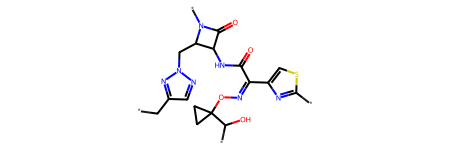

In [5]:
## To test the model, please provide the SMILES string for a scaffold here,
## placing * markers in the open position(s) where generation is to take place.
test_scaffold = 'C(*)c1cnn(CC2C(NC(=O)C(=NOC3(C(*)O)CC3)c3csc(*)n3)C(=O)N2(*))n1'
Chem.MolFromSmiles(test_scaffold)

Generated molecule # 0:
	SMILES string: C(NC1CCSc2ccccc2C1)c1cnn(CC2C(NC(=O)C(=NOC3(C(N)O)CC3)c3csc(N)n3)C(=O)N2(S(C)(=O)=O))n1
Generated molecule # 1:
	SMILES string: C(Cn1cncc1)c1cnn(CC2C(NC(=O)C(=NOC3(C(N)O)CC3)c3csc(N)n3)C(=O)N2(S(=O)(=O)C))n1
Generated molecule # 2:
	SMILES string: C(OC(=O)CC)c1cnn(CC2C(NC(=O)C(=NOC3(C(=O)O)CC3)c3csc(N)n3)C(=O)N2(S(=O)(=O)C))n1
Generated molecule # 3:
	SMILES string: C(COc1ccc([N+]([O-])=O)cc1)c1cnn(CC2C(NC(=O)C(=NOC3(C(C)O)CC3)c3csc(C)n3)C(=O)N2(C))n1
Generated molecule # 4:
	SMILES string: C(Nc1ncc2c(n1)-c1cc(-c3c[nH]nc3)ccc1CCC2)c1cnn(CC2C(NC(=O)C(=NOC3(C(=O)O)CC3)c3csc(N)n3)C(=O)N2(C))n1
Generated molecule # 5:
	SMILES string: C(=O)c1cnn(CC2C(NC(=O)C(=NOC3(C(=O)O)CC3)c3csc(N)n3)C(=O)N2(S(=O)(c2ccc(C)cc2)=O))n1
Generated molecule # 6:
	SMILES string: C(NCC)c1cnn(CC2C(NC(=O)C(=NOC3(C(F)O)CC3)c3csc(-c4cn(C)cn4)n3)C(=O)N2(C))n1
Generated molecule # 7:
	SMILES string: C(Nc1ccc(CC)cc1)c1cnn(CC2C(NC(=O)C(=NOC3(C(O)O)CC3)c3csc(N)n3)C(=O)N2(C))n1
Gener

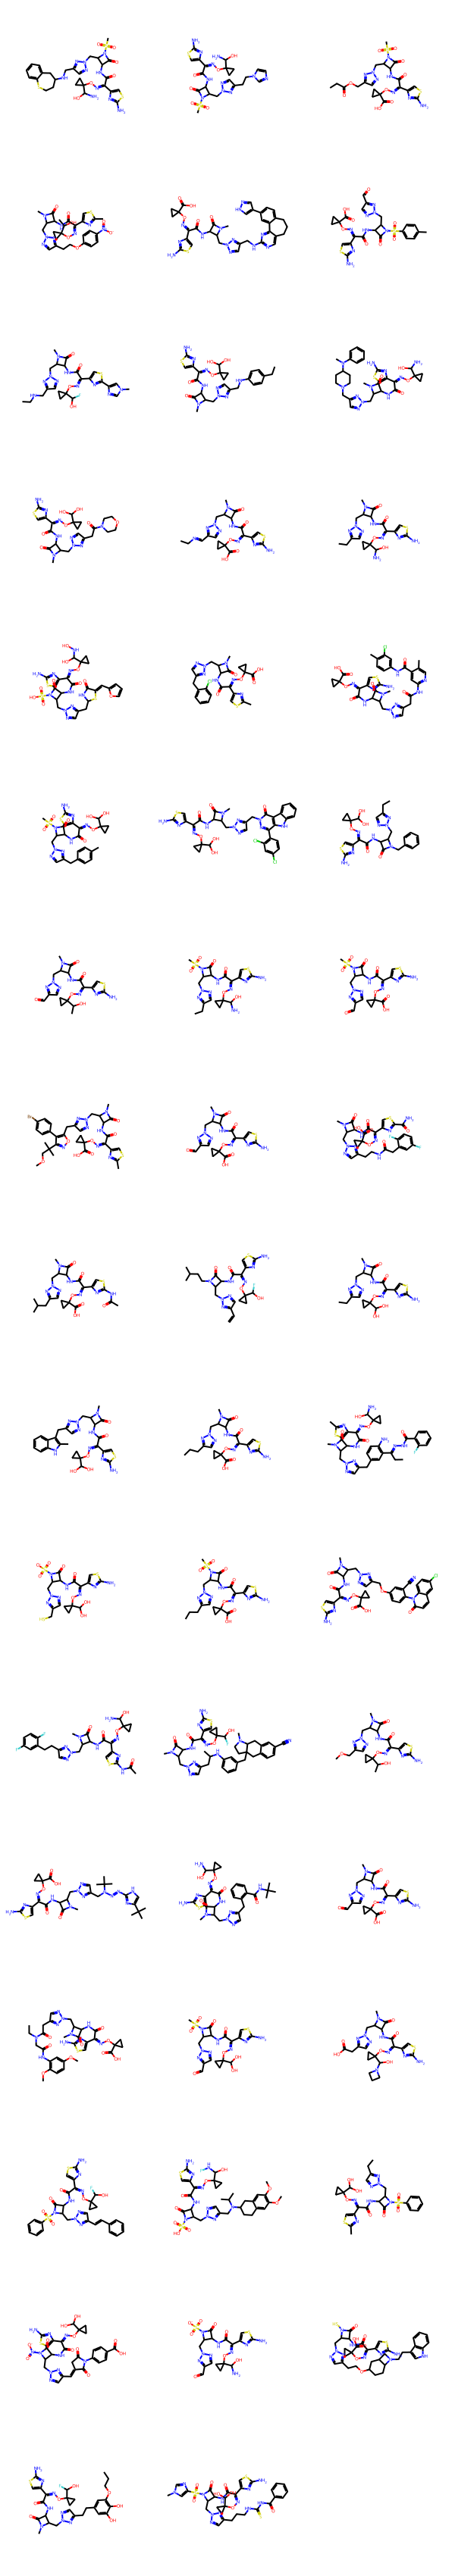

In [6]:
## This cell generates molecules based on the test scaffold
seqs, agent_likelihood, entropy = Agent.sample(pattern=test_scaffold, batch_size=3000)
smiles = seq_to_smiles(seqs, voc)
mols = []
funct_smiles = []
for s in smiles:
    m = Chem.MolFromSmiles(s)
    if m:
        mols.append(m)
        funct_smiles.append(s)
for idx, i in enumerate(funct_smiles):
    print("(Valid) generated molecule # {}:\n\tSMILES string: {}".format(idx, i))
Draw.MolsToGridImage(mols)

On a set of 2419 generated molecules based on the scaffold C(*)c1cnn(CC2C(NC(=O)C(=NOC3(C(*)O)CC3)c3csc(*)n3)C(=O)N2(*))n1, we obtain the following average metrics:
logP = -0.4307
SAS = 4.8019
QED = 0.1030
MW = 613.1128
HBA = -0.4307
HBD = 13.9740
We obtain the following validity and uniqueness results:
On average,
	the percentage of valid generated molecules is 0.8063
	the percentage of unique generated molecules is 0.8669

Generated molecule # 0:
	SMILES string: CN1C(=O)C(NC(=O)C(=NOC2(C(=O)O)CC2)c2csc(F)n2)C1Cn1ncc(CN)n1
Generated molecule # 1:
	SMILES string: Cc1ccc2[nH]c(SCc3cnn(CC4C(NC(=O)C(=NOC5(C(N)O)CC5)c5csc(N)n5)C(=O)N4C)n3)nc2c1
Generated molecule # 2:
	SMILES string: CS(=O)(=O)N1C(=O)C(NC(=O)C(=NOC2(C(O)O)CC2)c2csc(N)n2)C1Cn1ncc(C#N)n1
Generated molecule # 3:
	SMILES string: CNC(=O)Cc1cc(-c2nc(C(=NOC3(C(=O)O)CC3)C(=O)NC3C(=O)N(C)C3Cn3ncc(C=O)n3)cs2)cs1
Generated molecule # 4:
	SMILES string: CS(=O)(=O)N1C(=O)C(NC(=O)C(=NOC2(C(N)O)CC2)c2csc(N)n2)C1Cn1ncc(Cc2ccccc2)n1
Genera

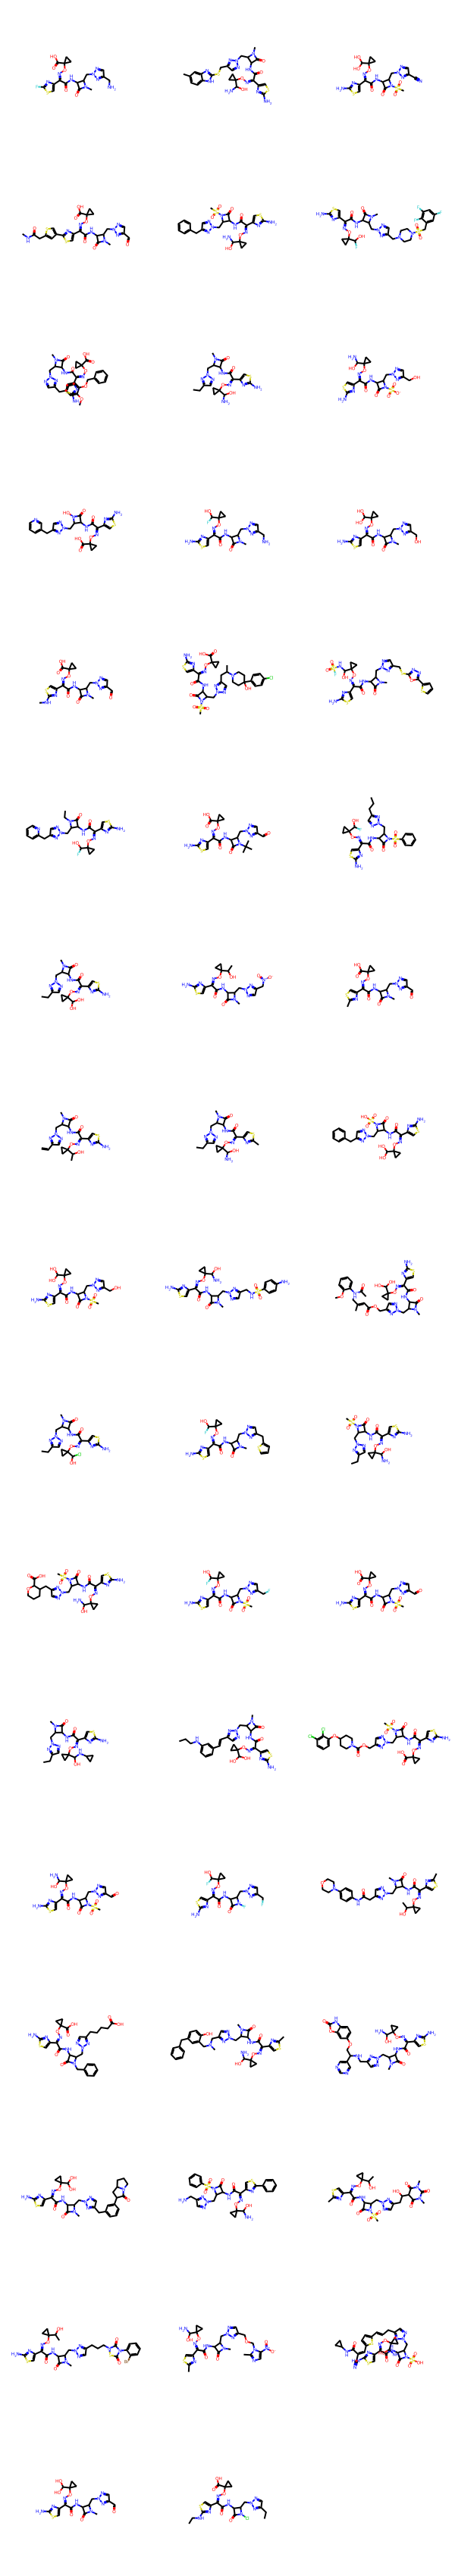

In [7]:
## This cell generates molecules based on the test scaffold and produces a report about their properties
test_scaffold = 'C(*)c1cnn(CC2C(NC(=O)C(=NOC3(C(*)O)CC3)c3csc(*)n3)C(=O)N2(*))n1'
validities, uniquenesses, MW, logP, SAS, qed_list, HA_list, HD_list, smiles = validity_and_uniqueness_assessement(test_scaffold, n_tryouts=3000, save_path='data/test_scaffold')
mols = []
funct_smiles = []
for s in smiles:
    m = Chem.MolFromSmiles(s)
    if m:
        mols.append(m)
        funct_smiles.append(s)
for idx, i in enumerate(funct_smiles):
    print("(Valid) generated molecule # {}:\n\tSMILES string: {}".format(idx, i))
Draw.MolsToGridImage(mols)